# Adversarial Information Factorization : 
application to Colored Mnist

By: Imen Ayadi

**NB:** <font color=red> This notebook was made on google colab. To run the code, please make sure that you uploaded the files data `models.py` and `function.py `</font>

## Useful librairies



In [ ]:
from skimage.io import imread
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
from PIL.ImageOps import fit
import tqdm
from tqdm import tqdm

from function import plot_losses, vae_loss_fn, save_input_args, \
sample_z, class_loss_fn, plot_norm_losses,\
binary_class_score #, one_hot
from function import label_switch_1 as label_switch
from models import CVAE1, DISCRIMINATOR, AUX
from models import DISCRIMINATOR as CLASSIFIER

import torch
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.autograd import grad
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy as bce
   
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline   

import torchvision
from torchvision import transforms,datasets
from torchvision.utils import make_grid, save_image

import numpy as np

import os
from os.path import join

import argparse

from PIL import Image
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from time import time

try:
    blah()
except:
    pass

## Making environments

In [ ]:
def color_grayscale_arr(arr, red=True):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. 
  """
  def __init__(self, root='./data', env='train1', size =28, e= [0.1, 0.2 ,0.9],transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)
    self.e=e
    self.size = size
    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True,transform=transforms.Resize(self.size))

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
      if np.random.uniform() < 0.25:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
      if idx < 20000:
        # 20% in the first training environment
        if np.random.uniform() < self.e[0]:
          color_red = not color_red
      elif idx < 40000:
        # 10% in the first training environment
        if np.random.uniform() < self.e[1]:
          color_red = not color_red
      else:
        # 90% in the test environment
        if np.random.uniform() < self.e[2]:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, red=color_red)

      if idx < 20000:
        train1_set.append((Image.fromarray(colored_arr), [binary_label,label]))
      elif idx < 40000:
        train2_set.append((Image.fromarray(colored_arr), [binary_label,label]))
      else:
        test_set.append((Image.fromarray(colored_arr), [binary_label,label]))


    torch.save(train1_set, os.path.join(self.root, 'train1.pt'))
    torch.save(train2_set, os.path.join(self.root, 'train2.pt'))
    torch.save(test_set, os.path.join(self.root, 'test.pt'))


## Load Data and make environments

In [ ]:
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [ ]:
train1_set = ColoredMNIST(root='./data', env='train1')
train2_set = ColoredMNIST(root='./data', env='train2')
test_set   = ColoredMNIST(root='./data', env='test')
train_set   = ColoredMNIST(root='./data', env='all_train')

In [ ]:
def plot_dataset_digits(dataset):
  fig,axs = plt.subplots(nrows=3,ncols=6, figsize=(13, 8))
  for i,ax  in enumerate(axs.ravel()):
    sample = np.random.randint(len(dataset))
    img, labels = dataset[sample]
    label=labels[0]#consider only the binary label
    # create subplot and append to ax
    ax.set_title("Label: " + str(label))  # set title
    ax.imshow(img)

  plt.show()  # finally, render the plot

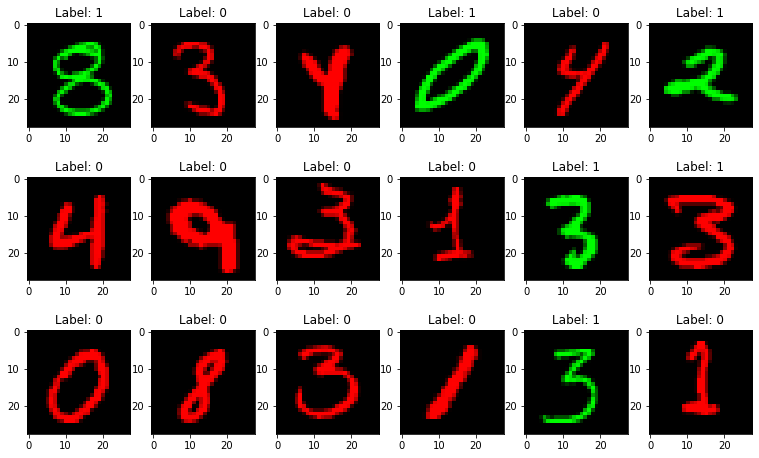

In [ ]:
plot_dataset_digits(train_set)

##1. Baseline

In [ ]:
!mkdir ./results
!mkdir ./results/baseline
exDirbase = './results/baseline'

mkdir: cannot create directory ‘./results’: File exists


In [ ]:
n_epochs = 10
batch_size = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

### Define the architecture

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits


In [ ]:
def test_model(model, device, test_loader, set_name="test set"):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, targets in test_loader:
      target = targets[0]
      data, target = data.to(device), target.to(device).float()
      output = model(data)
      test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum').item()  # sum up batch loss
      pred = torch.where(torch.gt(output, torch.Tensor([0.0]).to(device)),
                         torch.Tensor([1.0]).to(device),
                         torch.Tensor([0.0]).to(device))  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('Performance on {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    set_name, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  return 100. * correct / len(test_loader.dataset)


def erm_train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, targets) in enumerate(train_loader):
    target = targets[0]
    data, target = data.to(device), target.to(device).float()
    optimizer.zero_grad()
    output = model(data)
    loss = F.binary_cross_entropy_with_logits(output, target)
    loss.backward()
    optimizer.step()
  print('\nTrain Epoch: {} \tLoss: {:.6f}'.format(epoch+1, loss.item()))


### Train the model

In [ ]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
  ColoredMNIST(root='./data', env='all_train',transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                  ])),
  batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
  ColoredMNIST(root='./data', env='test',transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
  ])),
  batch_size=1000, shuffle=True, **kwargs)

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")

model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
  erm_train(model, device, train_loader, optimizer, epoch)
  test_model(model, device, train_loader, set_name='train set')
  test_model(model, device, test_loader)



Train Epoch: 1 	Loss: 0.377873
Performance on train set: Average loss: 0.4051, Accuracy: 33974/40000 (84.94%)
Performance on test set: Average loss: 1.5248, Accuracy: 1921/20000 (9.61%)

Train Epoch: 2 	Loss: 0.279767
Performance on train set: Average loss: 0.4022, Accuracy: 33983/40000 (84.96%)
Performance on test set: Average loss: 1.4382, Accuracy: 1902/20000 (9.51%)

Train Epoch: 3 	Loss: 0.243359
Performance on train set: Average loss: 0.3976, Accuracy: 33975/40000 (84.94%)
Performance on test set: Average loss: 1.5208, Accuracy: 1938/20000 (9.69%)

Train Epoch: 4 	Loss: 0.325356
Performance on train set: Average loss: 0.3970, Accuracy: 33981/40000 (84.95%)
Performance on test set: Average loss: 1.5923, Accuracy: 1918/20000 (9.59%)

Train Epoch: 5 	Loss: 0.383053
Performance on train set: Average loss: 0.3999, Accuracy: 33982/40000 (84.95%)
Performance on test set: Average loss: 1.5149, Accuracy: 1911/20000 (9.55%)

Train Epoch: 6 	Loss: 0.424887
Performance on train set: Average

**Conclusion:** Bad accuracy on the test set caused by the spurious corrolation

##2. AIF Network

### Set Hyperparameters

In [ ]:
###### Set Hyperparameters ######
EPSILON = 1e-6
batch_size = 32
batch_size_test = 1000
maxEpochs = 50
nz =100
lr1 = 2e-3
lr2 = 2e-3
fSize = 32
alpha= 1
delta = 1
gamma = 1
rho = 1
mom = 0.9
e=[0.2,0.3,0.9]
weightDecay = 0
beta = 1
eval_epoch = 1 #evaluate after each 5 epochs
!mkdir results

mkdir: cannot create directory ‘results’: File exists


### Build the network

In [ ]:
####### Create model #######
cvae = CVAE1(nz=nz, imSize=32, fSize=fSize)
dis = DISCRIMINATOR(imSize=32, fSize=fSize) 
aux = AUX(nz=nz)   
classer = CLASSIFIER(imSize=32, fSize=fSize) 

if cvae.useCUDA:
  print('using CUDA')
  cvae.cuda()
  dis.cuda()
  aux.cuda()
  classer.cuda()
else: print('\n *** NOT USING CUDA ***\n')

using CUDA


In [ ]:
###### Model Topology #####
print(cvae)
print(dis)
print(aux)

CVAE1(
  (enc1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (enc2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (enc3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (enc4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (encLogVar): Linear(in_features=1024, out_features=100, bias=True)
  (encMu): Linear(in_features=1024, out_features=100, bias=True)
  (encY): Linear(in_features=1024, out_features=1, bias=True)
  (dec1): Linear(in_features=101, out_features=1024, bias=True)
  (dec2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec2b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec3b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec4): ConvTranspose2d

### Train the model

In [ ]:
####### Create folders for results #######
!mkdir ./results/aif
!mkdir ./results/aif/test
!mkdir ./results/aif/train


exDirtest = './results/aif/test'
exDirtrain = './results/aif/train'


mkdir: cannot create directory ‘./results/aif’: File exists
mkdir: cannot create directory ‘./results/aif/test’: File exists
mkdir: cannot create directory ‘./results/aif/train’: File exists


In [ ]:
####### Define optimizer #######
optimizerCVAE = optim.Adam(cvae.parameters(), lr=lr1, weight_decay=weightDecay)  #specify the params that are being upated
optimizerDIS = optim.RMSprop(dis.parameters(), lr=lr1, alpha=mom, weight_decay=weightDecay)
optimizerAUX = optim.Adam(aux.parameters(), lr=lr1, weight_decay=weightDecay)

In [ ]:
###### Train and test loaders ######
trainset=ColoredMNIST(root='./data', env='all_train',size = 32,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                  ]))

train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True, **kwargs)

testset=ColoredMNIST(root='./data', env='test',size =32,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                  ]))
test_loader = torch.utils.data.DataLoader(testset,batch_size=batch_size_test, shuffle=True, **kwargs)

In [ ]:
###### Initialisation ######
losses = {'total':[], 'kl':[], 'bce':[], 'dis':[], 'gen':[], 'class':[], 'aux':[], 'auxEnc':[]}
Ns = len(train_set)  #no samples for train
Ns_ = len(test_set)
test_losses={'test_bce':[],'test_kl':[]}
Nb = len(train_loader) 

train_acc={'original':[],'reconstruction':[]}
test_acc={'original':[],'reconstruction':[]}

train_latent_identities=[]
test_latent_identities=[]

In [ ]:
def evaluate(cvae, testLoader,classer,done=False, e=1):  #after each "e" epochs , we evaluate the model
    cvae.eval()

    correct=0
    correct_rec=0
    Test_MSE = 0
    for i,data in enumerate(testLoader):
      xTest,yTests = data
      yTest = yTests[0]
      xTest = Variable(xTest.cuda()).float()
      yTest = Variable(yTest.cuda()).float()
    
      if cvae.useCUDA:
        z = Variable(torch.randn(xTest.size(0), nz).cuda()).float()
      else:
        z = Variable(torch.randn(xTest.size(0), nz)).float()

      #check reconstructions after each 10 epochs
      outputs, outMu, outLogVar, outY = cvae(xTest)

      bceLossTest, klLossTest = cvae.loss(rec_x=outputs, x=xTest, mu=outMu, logVar=outLogVar)
      outY = outY.flatten()
      predLabel = torch.gt(outY, 0.5)
      correct += (torch.eq(predLabel, yTest.type_as(predLabel)).float().sum()).data.item()


      z = cvae.re_param(outMu, outLogVar)
      
      _, _, yRec = cvae.encode(outputs)
      yRec = yRec.flatten()
      predLabel = torch.gt(yRec, 0.5)
      correct_rec += (torch.eq(predLabel, yTest.type_as(predLabel)).float().sum()).data.item()
      
      

      ########################################################################
      """This part is not very important; it build reconstructions after switching labels"""
      #try to switch labels and plot the associated reconstrunctions
      #rec1, rec0 = label_switch(xTest.data, yTest, cvae, exDir=exDirtest)

      #classer.eval()
      #yPred0 = classer(rec0)
      #y0 = Variable(torch.LongTensor(yPred0.size()).fill_(0)).type_as(yTest)
      #class0 = binary_class_score(yPred0, y0, thresh=0.5)
      #yPred1 = classer(rec1)
      #y1 =    Variable(torch.LongTensor(yPred1.size()).fill_(1)).type_as(yTest)
      #class1 = binary_class_score(yPred1, y1, thresh=0.5)
      #Class0 = class0.data.item()
      #Class1 = class1.data.item()
      ########################################################################

      Test_MSE += F.mse_loss(outputs, xTest).data.item()
      
      #save reconstructions for the last epoch only to avoid memory crash
      if e==maxEpochs-1:
          test_latent_identities.append([z.cpu(),xTest.cpu(),yTests[1]])
          save_image(xTest.data, join(exDirtest,'test_input_'+str(i)+'.png'))
          save_image(outputs.data, join(exDirtest,'test_reconstruction_'+str(i)+'.png'))

    print('**** Reconstruction Error = ',np.round(Test_MSE/Ns_,6),' / Prediction Acc on originals = ',np.round(correct/Ns_,6),
          ' / Prediction Acc on reconstructions = ',np.round(correct_rec/Ns_,6),' ***')
    test_acc['original'].append(correct/Ns_)
    test_acc['reconstruction'].append(correct_rec/Ns_)
    print('**** KL Test Loss = ',np.round(klLossTest.data.item()/Ns_,6),' / BCE Test Loss = ',np.round(bceLossTest.data.item()/Ns_,6),' ***')

    return bceLossTest.data.item()/Ns_,klLossTest.data.item()/Ns_



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


saving params...
Epoch =  1 : Total Loss =  1.046124 
 >>>> KL =  0.000727  \ DISC =  63.528035  \ AUX =  0.021713  \ required time =  51.796 
 >>>> Classif. Acc on original samples =  0.544725 
 >>>> Classif. Acc on reconstructed samples =  0.4999
evaluating...
**** Reconstruction Error =  2.6e-05  / Prediction Acc on originals =  0.50305  / Prediction Acc on reconstructions =  0.4998  ***
**** KL Test Loss =  0.000151  / BCE Test Loss =  0.019052  ***
saving params...
Epoch =  2 : Total Loss =  0.377369 
 >>>> KL =  0.008058  \ DISC =  66.666672  \ AUX =  0.020627  \ required time =  51.379 
 >>>> Classif. Acc on original samples =  0.655775 
 >>>> Classif. Acc on reconstructed samples =  0.61695
evaluating...
**** Reconstruction Error =  1.9e-05  / Prediction Acc on originals =  0.09875  / Prediction Acc on reconstructions =  0.1064  ***
**** KL Test Loss =  0.000266  / BCE Test Loss =  0.014158  ***
saving params...
Epoch =  3 : Total Loss =  0.278926 
 >>>> KL =  0.010078  \ DISC 

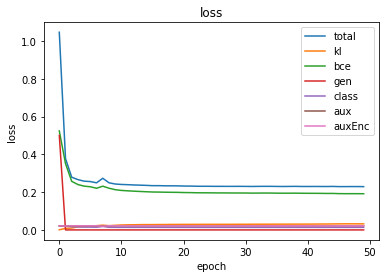

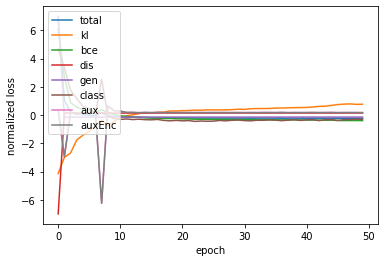

In [141]:
####### Start Training #######

for e in range(maxEpochs):
    cvae.train()
    dis.train()
    
    correct = 0
    correct_rec = 0
    epochLoss = 0
    epochLoss_kl = 0
    epochLoss_bce = 0
    epochLoss_dis = 0
    epochLoss_gen = 0
    epochLoss_class = 0
    epochLoss_aux = 0
    epochLoss_auxEnc = 0

    TIME = time()
    for i,data in enumerate(train_loader):
      x,ys  = data
      y = ys[0]
      x = Variable(x.cuda()).float()
      y = Variable(y.cuda()).float()
      #get ouput, clac loss, calc all grads, optimise
      #VAE loss
      outRec, outMu, outLogVar, predY = cvae(x)
      z = cvae.re_param(outMu, outLogVar)
      
      bceLoss, klLoss = cvae.loss(rec_x=outRec, x=x, mu=outMu, logVar=outLogVar)
      
      vaeLoss = bceLoss +alpha* klLoss
      
      #Classification loss #not on reconstructed sample
      predY =predY.flatten().float()
      classLoss = F.binary_cross_entropy(predY, y)
      vaeLoss += rho * classLoss
      predLabel = torch.gt(predY, 0.5)
      correct += (torch.eq(predLabel, y.type_as(predLabel)).float().sum()).data.item()

      #Class loss on reconstruction
      _, _, yRec = cvae.encode(outRec)
      yRec = yRec.flatten()

      classRecLoss = F.binary_cross_entropy(yRec, y)
      predLabel = torch.gt(yRec, 0.5)
      correct_rec += (torch.eq(predLabel, y.type_as(predLabel)).float().sum()).data.item()
      vaeLoss += beta * classRecLoss

      #Train the encoder to NOT predict y from z
      auxY = aux(z).flatten()  #not detached update the encoder!
      auxEncLoss = F.binary_cross_entropy(auxY.type_as(y), y)  
      vaeLoss -= gamma * auxEncLoss

      #Train the aux net to predict y from z
      auxY = aux(z.detach()).flatten()  #detach: to ONLY update the AUX net #.detach
      auxLoss = F.binary_cross_entropy(auxY.type_as(y), y)
      


      #DIS loss
      pXreal = dis(x)
      pXfakeRec = dis(outRec.detach()) ##.detach
      zRand = sample_z(x.shape[0], nz, cvae.useCUDA)
      yRand = y
      w = cvae.decode(yRand.unsqueeze(-1), zRand).detach()
      pXfakeRand = dis(w)
      fakeLabel = Variable(torch.Tensor(pXreal.size()).zero_()).type_as(pXreal)
      realLabel = Variable(torch.Tensor(pXreal.size()).fill_(1)).type_as(pXreal)
      disLoss = (1/3) * (bce(pXreal, realLabel,reduction='sum') + \
        bce(pXfakeRec, fakeLabel, reduction='sum') + \
        bce(pXfakeRand, fakeLabel, reduction='sum')) / pXreal.size(1)

      #GEN loss
      pXfakeRec = dis(outRec)
      pXfakeRand = dis(cvae.decode(yRand.unsqueeze(-1), zRand))
      genLoss = 0.5 * (bce(pXfakeRec, realLabel,reduction='sum') +\
        bce(pXfakeRand, realLabel, reduction='sum')) / pXfakeRec.size(1)

       
      #include the GENloss (the encoder loss) with the VAE loss
      vaeLoss += delta * genLoss

      #zero the grads - otherwise they will be acculated
      #fill in grads and do updates:
      optimizerCVAE.zero_grad()
      vaeLoss.backward() 
      optimizerCVAE.step()

      optimizerAUX.zero_grad()
      auxLoss.backward()
      optimizerAUX.step()

      optimizerDIS.zero_grad()
      disLoss.backward()
      optimizerDIS.step()

      epochLoss += vaeLoss.data.item()
      epochLoss_kl += klLoss.data.item()
      epochLoss_bce += bceLoss.data.item()
      epochLoss_gen += genLoss.data.item()
      epochLoss_dis += disLoss.data.item()
      epochLoss_class += classLoss.data.item() 
      epochLoss_aux += auxLoss.data.item()
      epochLoss_auxEnc += auxEncLoss.data.item()

      #save reconstructions for the last epoch only to avoid memory crash
      if e==maxEpochs-1:
          train_latent_identities.append([z.cpu(),x.cpu(),ys[1]])
          save_image(x.data, join(exDirtrain,'train_input_'+str(i)+'.png'))
          save_image(outRec.data, join(exDirtrain,'train_reconstruction_'+str(i)+'.png'))

    cvae.save_params(exDir=exDirtrain)

    losses['total'].append(epochLoss/Ns)
    losses['kl'].append(epochLoss_kl/Ns)
    losses['bce'].append(epochLoss_bce/Ns)
    losses['dis'].append(epochLoss_dis/Ns)
    losses['gen'].append(epochLoss_gen/Ns)
    losses['class'].append(epochLoss_class/Ns)
    losses['aux'].append(epochLoss_aux/Ns)
    losses['auxEnc'].append(epochLoss_auxEnc/Ns)
    train_acc['original'].append(correct/Ns)
    train_acc['reconstruction'].append(correct_rec/Ns)
    
    print("Epoch = ",e+1,": Total Loss = ",np.round(epochLoss/Ns,6),"\n >>>> KL = ",np.round(epochLoss_kl/Ns,6),
          " \ DISC = ",np.round(epochLoss_dis/Ns,6), " \ AUX = ",np.round(epochLoss_aux/Ns,6)," \ required time = ",np.round(time()-TIME,3),
          '\n >>>> Classif. Acc on original samples = ',np.round(correct/Ns,6),
          '\n >>>> Classif. Acc on reconstructed samples = ',np.round(correct_rec/Ns,6))

    if e%eval_epoch==0:
       print('evaluating...')
       normbceLossTest,klLossTest = evaluate(cvae, test_loader,classer, e=e)
       test_losses['test_bce'].append(normbceLossTest)
       test_losses['test_kl'].append(klLossTest)


print('evaluating...')
normbceLossTest,klLossTest = evaluate(cvae, test_loader,classer, e=maxEpochs-1)
test_losses['test_bce'].append(normbceLossTest)
test_losses['test_kl'].append(klLossTest)

losses_ = {}
for k in list(losses.keys()):
  if k!='dis':
    losses_[k]= losses[k]
    
plot_losses(losses_, exDirtrain,epochs=e+1)
plot_norm_losses(losses, exDirtrain,epochs=e+1)


**Comments**:
- After trying lots of hyperparameters and various tricks, this implementation 
seems to consistently achieve the paper-reported values 
(train accuracy > 60%, test accuracy > 60%), though there might be a bit of instability depending on the random seed.

- The most common failure case is the accuracy is stuck at 50% for all environments. This also happen with IRM : when the gradient norm penalty term is weighted
too highly relative to the ERM term, $\Phi$ converges to a function that 
returns the same value for all inputs. The classifier cannot recover from this point.
If the intermediate representation is the same regardless of input, then *any*
classifier is the ideal classifier, resulting in the penalty gradient being 0.

- Another failure case is when the optimization essentially acts as in ERM (train accuracy > 80%, test accuracy ~10%). In terms of IRM, this means that the gradient norm penalty is too low. 

- For IRM, we know a trick that resolves these two failure cases : scheduled 
increase of the gradient norm penalty weight. For AIF, we add the auxilary network.

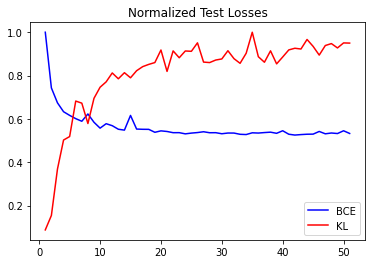

In [143]:
xlist = range(1,1+len(test_losses['test_bce']))
plt.plot(xlist,[x/max(test_losses['test_bce']) for x in test_losses['test_bce']] ,c = 'b',label="BCE")
plt.plot(xlist,[x/max(test_losses['test_kl']) for x in test_losses['test_kl']] ,c = 'r',label="KL")
plt.title("Normalized Test Losses")
plt.legend()
plt.show()

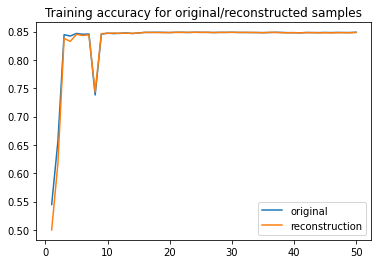

In [144]:
xxlist = range(1,1+len(train_acc['original']))
plt.plot(xxlist,train_acc['original'],label='original')
plt.plot(xxlist,train_acc['reconstruction'],label='reconstruction')
plt.title("Training accuracy for original/reconstructed samples")
plt.legend()
plt.show()

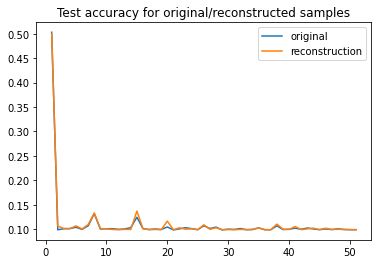

In [145]:
plt.plot(xlist,test_acc['original'],label='original')
plt.plot(xlist,test_acc['reconstruction'],label='reconstruction')
plt.title("Test accuracy for original/reconstructed samples")
plt.legend()
plt.show()

### Reconstructions 

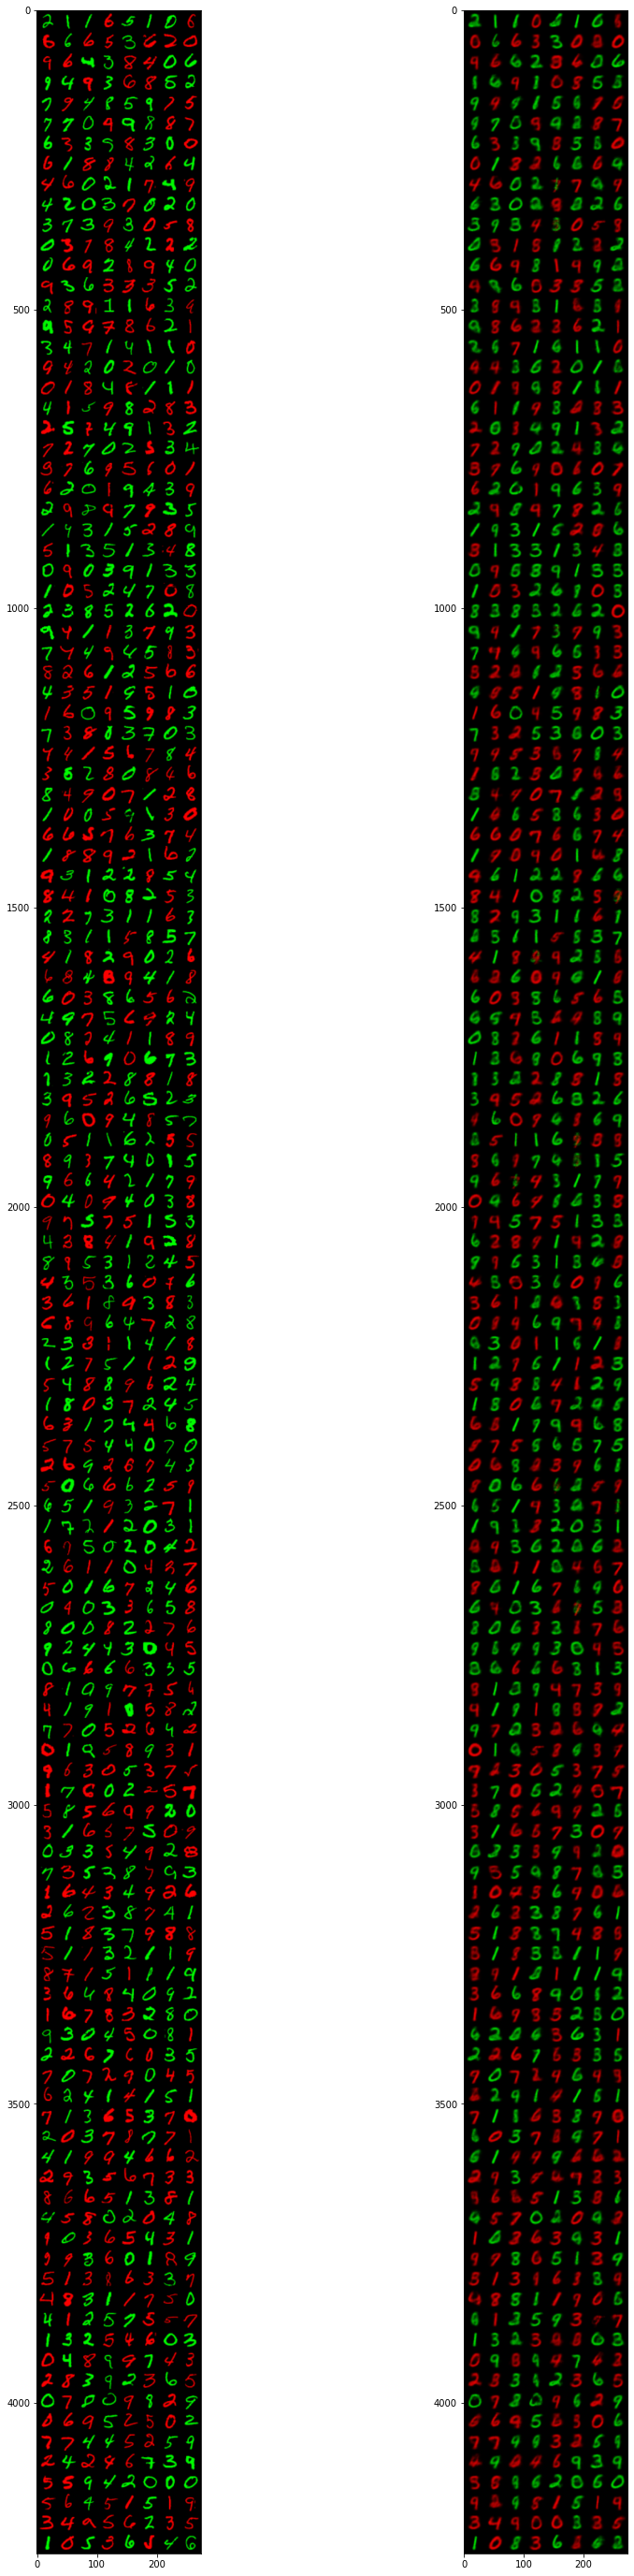

In [155]:
#plot for a given batch

img = plt.imread('./results/aif/test/test_input_0.png')
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,50))
ax[0].imshow(img)
imgrec = plt.imread('./results/aif/test/test_reconstruction_0.png')
ax[1].imshow(imgrec)

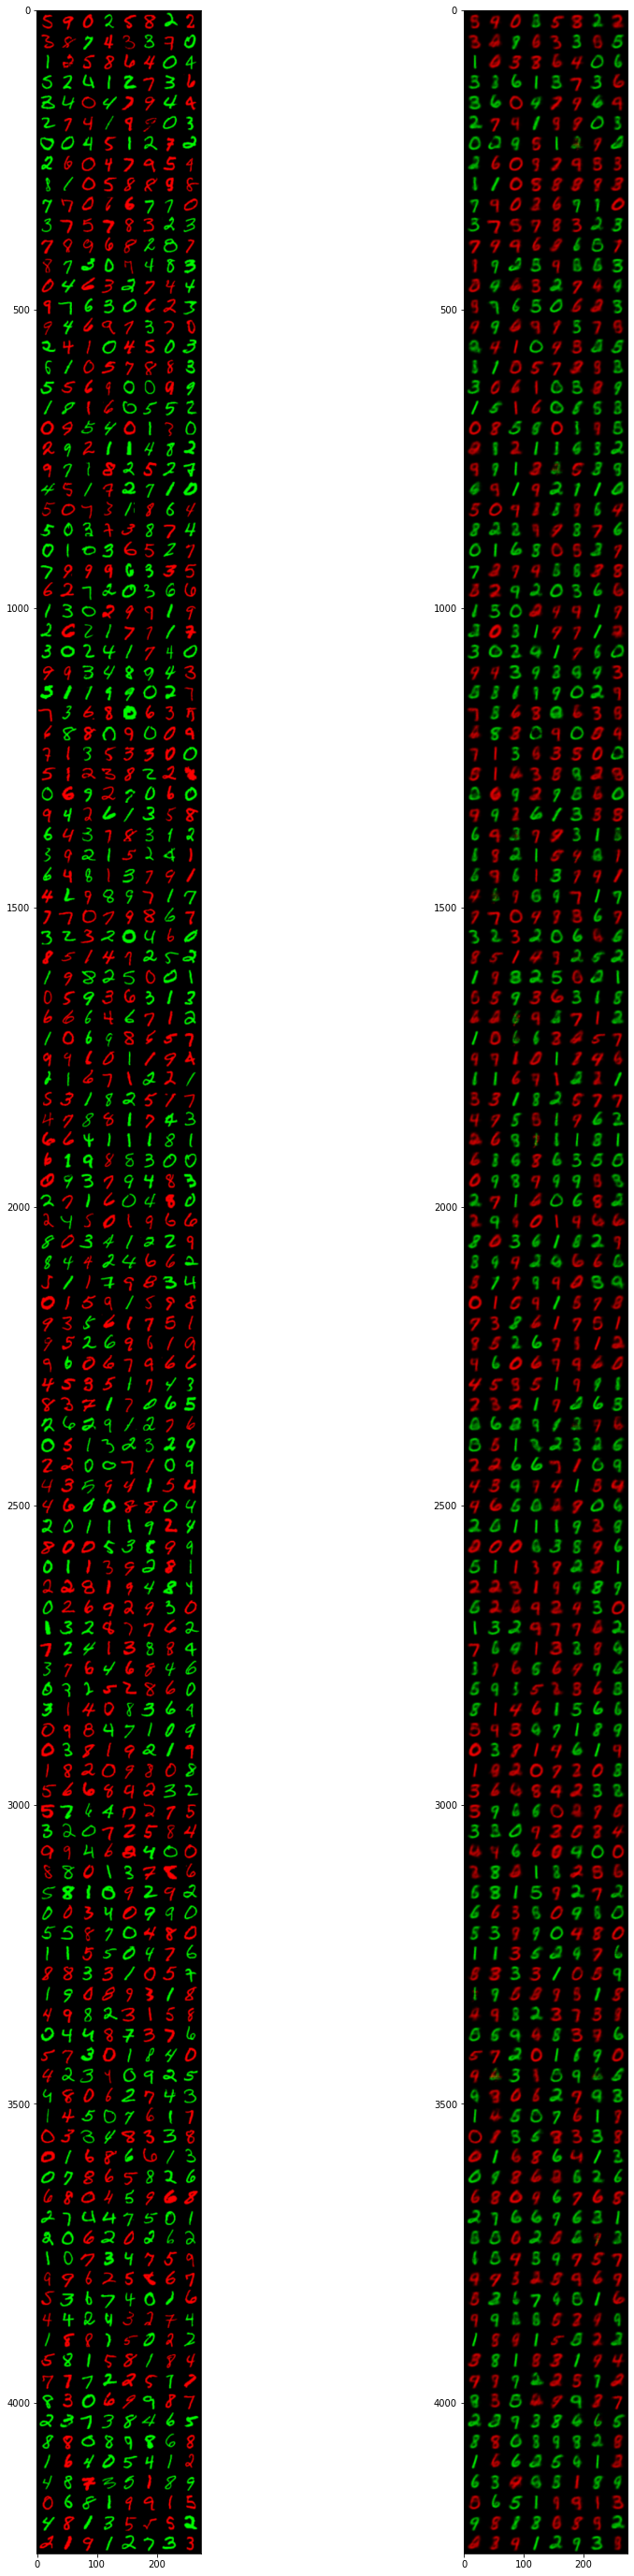

In [156]:
img = plt.imread('./results/aif/test/test_input_10.png')
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,50))
ax[0].imshow(img)
imgrec = plt.imread('./results/aif/test/test_reconstruction_10.png')
ax[1].imshow(imgrec)

### Digit recognition

In [146]:
Z_train =[train_latent_identities[i][0][j].detach().numpy()  for j in range(batch_size) for i in range(len(train_latent_identities))]
digit_train =[train_latent_identities[i][2][j].item() for j in range(batch_size)for i in range(len(train_latent_identities))]
X_train =[train_latent_identities[i][1][j].detach().numpy()  for j in range(batch_size) for i in range(len(train_latent_identities))]

In [147]:
print(Z_train[0].shape)

(100,)


In [148]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(Z_train, digit_train)
score = clf.score(Z_train, digit_train)
print(list(clf.predict(Z_train)))
print(digit_train)
print(score)

[1, 9, 7, 4, 0, 7, 4, 3, 6, 9, 6, 3, 7, 8, 4, 5, 0, 0, 1, 0, 1, 9, 6, 1, 6, 9, 6, 2, 1, 2, 6, 7, 1, 3, 0, 3, 4, 2, 4, 1, 1, 1, 6, 7, 5, 3, 3, 7, 1, 3, 7, 0, 8, 9, 9, 6, 5, 0, 7, 0, 3, 3, 0, 5, 0, 0, 1, 8, 7, 3, 3, 3, 8, 6, 0, 4, 5, 3, 2, 1, 0, 3, 6, 9, 9, 4, 0, 4, 1, 7, 8, 0, 8, 8, 1, 8, 9, 8, 8, 0, 0, 8, 0, 2, 0, 9, 4, 3, 4, 5, 3, 0, 6, 6, 9, 4, 9, 1, 8, 3, 3, 6, 1, 1, 0, 6, 1, 4, 0, 6, 0, 2, 4, 7, 3, 6, 1, 2, 5, 6, 7, 0, 0, 8, 4, 0, 6, 3, 0, 8, 5, 6, 0, 6, 2, 8, 4, 1, 1, 3, 0, 1, 3, 2, 0, 0, 6, 9, 4, 8, 7, 7, 7, 3, 1, 4, 8, 0, 0, 9, 4, 5, 4, 8, 3, 5, 8, 1, 8, 0, 7, 7, 7, 0, 7, 1, 2, 9, 2, 1, 1, 6, 9, 0, 1, 2, 1, 0, 6, 4, 4, 1, 0, 4, 2, 3, 0, 1, 0, 8, 3, 1, 1, 6, 3, 1, 4, 5, 6, 0, 0, 9, 3, 6, 2, 9, 7, 7, 1, 6, 0, 4, 5, 9, 4, 7, 8, 1, 6, 8, 9, 4, 3, 9, 0, 2, 7, 6, 6, 3, 3, 4, 1, 7, 0, 8, 4, 7, 6, 7, 7, 0, 6, 1, 9, 0, 5, 3, 4, 6, 7, 6, 4, 0, 5, 1, 4, 5, 0, 4, 1, 7, 3, 0, 2, 0, 0, 8, 3, 1, 6, 6, 5, 6, 8, 2, 3, 3, 8, 7, 6, 6, 3, 0, 4, 4, 3, 1, 2, 4, 9, 4, 5, 4, 0, 3, 3, 1, 0, 3, 7, 0, 7, 

In [149]:
Z_test =[test_latent_identities[i][0][j].detach().numpy()  for j in range(batch_size_test) for i in range(len(test_latent_identities))]
digit_test =[test_latent_identities[i][2][j].item() for j in range(batch_size_test)for i in range(len(test_latent_identities))]
y = clf.predict(Z_test)
print(list(y))
print(digit_test)
print(clf.score(Z_test,digit_test))

[2, 6, 3, 9, 7, 3, 0, 5, 0, 3, 7, 0, 5, 6, 3, 3, 6, 8, 6, 8, 0, 2, 8, 6, 9, 3, 7, 5, 6, 6, 3, 5, 0, 7, 9, 1, 9, 6, 9, 1, 6, 8, 8, 2, 7, 0, 3, 0, 7, 5, 6, 5, 1, 3, 5, 0, 1, 1, 4, 1, 1, 6, 1, 2, 7, 7, 6, 6, 3, 1, 2, 0, 0, 4, 2, 2, 3, 4, 7, 5, 0, 7, 4, 9, 4, 7, 0, 6, 0, 2, 2, 1, 3, 2, 8, 4, 5, 5, 2, 2, 1, 3, 3, 2, 3, 2, 7, 7, 7, 6, 6, 7, 2, 7, 7, 1, 8, 7, 4, 7, 0, 2, 5, 9, 3, 3, 2, 3, 0, 4, 9, 0, 3, 5, 9, 7, 6, 9, 1, 1, 6, 8, 0, 8, 3, 8, 2, 9, 1, 0, 3, 7, 3, 6, 1, 0, 3, 6, 6, 2, 2, 6, 1, 7, 0, 3, 7, 1, 4, 6, 9, 6, 7, 5, 3, 1, 8, 4, 3, 1, 4, 3, 1, 7, 6, 8, 7, 4, 4, 6, 0, 2, 3, 5, 7, 6, 6, 8, 6, 8, 3, 7, 7, 9, 2, 4, 1, 2, 7, 4, 4, 6, 9, 0, 1, 5, 3, 4, 3, 9, 4, 4, 7, 4, 3, 2, 4, 7, 3, 7, 5, 3, 3, 4, 8, 6, 0, 0, 8, 5, 0, 1, 5, 2, 1, 4, 2, 7, 0, 7, 7, 6, 5, 5, 3, 9, 6, 3, 2, 2, 5, 9, 6, 2, 3, 1, 0, 7, 4, 1, 0, 0, 8, 6, 7, 9, 3, 7, 4, 0, 1, 1, 6, 0, 2, 1, 7, 8, 8, 2, 4, 3, 4, 2, 4, 1, 7, 0, 8, 0, 2, 4, 5, 0, 1, 5, 0, 0, 4, 3, 7, 8, 3, 4, 4, 2, 9, 9, 0, 8, 0, 7, 9, 9, 3, 7, 6, 0, 7, 0, 0, 3, 4, 